In [1]:
!mkdir ADNI

In [2]:
# !ls . | grep processed | while read f; do tar -xf $f -C ADNI; rm $f; done;
!tar -xf temporary.tar.gz -C ADNI

In [1]:
import nibabel as nib

In [2]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [3]:
import glob

images = glob.glob('ADNI/**/*.nii.gz', recursive=True)

In [26]:
corrupted = check_files(images)

In [27]:
corrupted

[]

# CNN - pretrain

## Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary

class ConvBlock(nn.Module):

  def __init__(self):
    super(ConvBlock, self).__init__()

    self.conv_0_1 = nn.Conv3d(1, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='same')
    self.bn_0 = nn.BatchNorm3d(15)
    self.conv_0_p = nn.Conv3d(15, 15, kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv_1_1 = nn.Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='same')
    self.bn_1 = nn.BatchNorm3d(15)
    self.conv_1_2 = nn.Conv3d(15, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='same')

    # merge1: layer 0 and layer 1

    self.bn_2_1 = nn.BatchNorm3d(30)
    self.conv_2_1 = nn.Conv3d(30, 25, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    self.bn_2_2 = nn.BatchNorm3d(25)
    self.conv_2_2 = nn.Conv3d(25, 25, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='same')
    self.conv_2_cut = nn.Conv3d(30, 15, kernel_size=(2, 2, 2), stride=(2, 2, 2)) # input from merge 1

    # merge2: layer2 and the cut2

    self.bn_3_1 = nn.BatchNorm3d(40)
    self.conv_3_1 = nn.Conv3d(40, 35, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    self.bn_3_2 = nn.BatchNorm3d(35)
    self.conv_3_2 = nn.Conv3d(35, 35, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='same')
    self.conv_3_cut = nn.Conv3d(40, 25, kernel_size=(2, 2, 2), stride=(2, 2, 2)) # input from merge 2

    # merge3: layer3 and the cut3

    self.bn_4 = nn.BatchNorm3d(60)
    self.conv_4_1 = nn.Conv3d(60, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='valid')
    self.conv_4_2 = nn.Conv3d(30, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='valid')


  def forward(self, x):

    x = self.conv_0_1(x)
    x = F.relu(self.bn_0(x))
    x1 = self.conv_0_p(x)

    x = self.conv_1_1(x1)
    x = F.dropout(F.relu(self.bn_1(x)), p=0.2) #?
    x = self.conv_1_2(x)

    x2 = torch.cat((x1, x), dim=1) # merge_1

    x = F.relu(self.bn_2_1(x2))
    x = self.conv_2_1(x)
    x = F.relu(self.bn_2_2(F.dropout(x, p=0.2)))
    x = self.conv_2_2(x)

    xc2 = self.conv_2_cut(x2)
    x3 = torch.cat((x, xc2), dim=1) # merge_2

    x = F.relu(self.bn_3_1(x3))
    x = self.conv_3_1(x)
    x = F.relu(self.bn_3_2(F.dropout(x, p=0.2)))
    x = self.conv_3_2(x)

    xc3 = self.conv_3_cut(x3)
    x4 = torch.cat((x, xc3), dim=1) # merge_3

    x = F.relu(self.bn_4(x4))
    x = self.conv_4_1(x)
    x = self.conv_4_2(x)

    return x


In [11]:
summary(ConvBlock().cuda(), (1, 50, 42, 42))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 15, 50, 42, 42]             420
       BatchNorm3d-2       [-1, 15, 50, 42, 42]              30
            Conv3d-3       [-1, 15, 25, 21, 21]           1,815
            Conv3d-4       [-1, 15, 25, 21, 21]           6,090
       BatchNorm3d-5       [-1, 15, 25, 21, 21]              30
            Conv3d-6       [-1, 15, 25, 21, 21]           6,090
       BatchNorm3d-7       [-1, 30, 25, 21, 21]              60
            Conv3d-8       [-1, 25, 12, 10, 10]           6,025
       BatchNorm3d-9       [-1, 25, 12, 10, 10]              50
           Conv3d-10       [-1, 25, 12, 10, 10]          16,900
           Conv3d-11       [-1, 15, 12, 10, 10]           3,615
      BatchNorm3d-12       [-1, 40, 12, 10, 10]              80
           Conv3d-13          [-1, 35, 6, 5, 5]          11,235
      BatchNorm3d-14          [-1, 35, 

In [5]:
class ActualCNN(nn.Module):

  def __init__(self):
    super(ActualCNN, self).__init__()

    self.conv_block = ConvBlock()

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(60, 300)
    self.fc2 = nn.Linear(300, 50)
    self.fc3 = nn.Linear(50, 3)

  def forward(self, x):

    x = self.conv_block(x)

    x = self.flatten(x)

    x = F.relu(F.dropout(self.fc1(x), p=0.2))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.softmax(x, dim=1)

In [13]:
summary(ActualCNN().cuda(), (1, 50, 42, 42))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 15, 50, 42, 42]             420
       BatchNorm3d-2       [-1, 15, 50, 42, 42]              30
            Conv3d-3       [-1, 15, 25, 21, 21]           1,815
            Conv3d-4       [-1, 15, 25, 21, 21]           6,090
       BatchNorm3d-5       [-1, 15, 25, 21, 21]              30
            Conv3d-6       [-1, 15, 25, 21, 21]           6,090
       BatchNorm3d-7       [-1, 30, 25, 21, 21]              60
            Conv3d-8       [-1, 25, 12, 10, 10]           6,025
       BatchNorm3d-9       [-1, 25, 12, 10, 10]              50
           Conv3d-10       [-1, 25, 12, 10, 10]          16,900
           Conv3d-11       [-1, 15, 12, 10, 10]           3,615
      BatchNorm3d-12       [-1, 40, 12, 10, 10]              80
           Conv3d-13          [-1, 35, 6, 5, 5]          11,235
      BatchNorm3d-14          [-1, 35, 

## dataset creation

In [6]:
import pandas as pd

df = pd.read_csv('ADNI1_Complete_3Yr_1.5T_4_09_2024.csv')
df = df.query('Description in ["MPR-R; GradWarp; B1 Correction; N3; Scaled", "MPR; GradWarp; B1 Correction; N3; Scaled"]').query('Visit in ["sc", "m06", "m12", "m18", "m24", "m36"]').reset_index(drop=True)

In [7]:
from sklearn.model_selection import train_test_split

Subjects, Groups = df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, test_subjects = train_test_split(Subjects, test_size=0.1, random_state=22, stratify=Groups)

train_df = df[df['Subject'].isin(train_subjects)][['Image Data ID','Group']]
train_images, train_labels = train_df.T.to_numpy()

test_df = df[df['Subject'].isin(test_subjects)][['Image Data ID','Group']]
test_images, test_labels = test_df.T.to_numpy()

In [8]:
def find_min_max(images):

  min_i = float("inf")
  max_i = -float("inf")

  for image_path in images:

    try:

      nifti_img = nib.load(image_path)

      img_data = nifti_img.get_fdata()

      min_i = min(img_data.min(), min_i)
      max_i = max(img_data.max(), max_i)

    except Exception as e:
      print(f'there was a problem fetching the image! PATH: {image_path}')

  return min_i, max_i

In [17]:
# total_min, total_max = find_min_max(images) # print(total_min, total_max) -> 0.0 146.20672607421875

In [9]:
import re

def make_id_translator(paths):
  return {re.search('(I\d{3,6})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [10]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [11]:
train_image_paths = [id_to_path[k] for k in train_images]

In [12]:
test_set = list(zip(test_images, test_labels))

test_set = list(filter(image_exists, test_set))

test_images, test_labels = zip(*test_set)

In [13]:
test_image_paths = [id_to_path[k] for k in test_images]

In [14]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder

minimum = 0.0
maximum = 146.20672607421875

class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Min max scale to (-1, 1) range
        # img_data = ((img_data - minimum) / (maximum - minimum)) * 2 - 1
        img_data = ((img_data - minimum) / (maximum - minimum))

        # Extract the non-zero intensity space
        img_data = img_data[44:-44, 44:-44, 28:-28]

        # subsample by the factor of 4
        img_data = img_data[::4,::4,::4]

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (42, 42, 50) -> (50, 42, 42)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_test_encoded = le.transform(test_labels)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=3).float()
y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_encoded), num_classes=3).float()

# # Define transformations if needed
# transform = transforms.Compose([
#     # Add your transformations here if needed
# ])

# Create custom datasets
train_dataset = CNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
test_dataset = CNNDataset(file_paths=test_image_paths, labels=y_test_one_hot)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [15]:
len(train_dataset)

1376

In [16]:
len(test_dataset)

157

In [17]:
next(iter(train_loader))[0][0].shape

torch.Size([1, 50, 42, 42])

## training

In [18]:
import shutil
import os

In [19]:
def save_checkpoint(model, optimizer, epoch, filename, train_losses, test_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    save_path = '/home/parham/Desktop/Project/features/crnn/train/checkpoints'

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(model, optimizer, filename):
    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    return model, optimizer, epoch, train_losses, test_losses


In [20]:
def validate(model, dataloader):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == torch.argmax(target, dim=1)).sum().item()

  accuracy = correct / total

  model.train()
  return accuracy

def plot(losses, labels):

  assert len(losses) == len(labels)

  for (loss, label) in list(zip(losses, labels)):
    plt.plot(loss, label=label)
    plt.plot(loss, label=label)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

In [21]:
params_filename = 'checkpoint.pth'

In [32]:
# !cp '/content/drive/MyDrive/Utils/CRNN-R_Cui/weights/cnn/checkpoint.pth' .

In [ ]:
import torch
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = ActualCNN()
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.8, rho=0.7, eps=1e-08, weight_decay=0)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
# model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint.pth')

# Number of training epochs
num_epochs = 100

# Training loop
for epoch in range(s_epoch + 1, num_epochs):
    model.train()

    epoch_train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, torch.argmax(target, dim=1))
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print training statistics
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

    epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    correct = 0
    total = 0

    epoch_valid_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()
            loss = criterion(output, torch.argmax(target, dim=1))
            epoch_valid_loss += loss.item()

    epoch_valid_loss = epoch_valid_loss / len(test_loader)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    valid_accuracy.append(accuracy)


    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch, params_filename, train_losses, valid_losses)
        train_accuracy = validate(model, train_loader)
        print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
        print(f'Training Loss: {epoch_train_loss:.4f}')


Epoch 1/100, Batch 1/21, Loss: 1.0951720476150513
Epoch 1/100, Batch 11/21, Loss: 1.0865634679794312
Epoch 1/100, Batch 21/21, Loss: 1.0464881658554077
Validation Accuracy: 43.75%
Validation Loss: 1.0858
Epoch 2/100, Batch 1/21, Loss: 1.0754432678222656
Epoch 2/100, Batch 11/21, Loss: 1.1140562295913696
Epoch 2/100, Batch 21/21, Loss: 1.0517685413360596
Validation Accuracy: 43.75%
Validation Loss: 1.0745
Epoch 3/100, Batch 1/21, Loss: 1.0502065420150757
Epoch 3/100, Batch 11/21, Loss: 1.056660771369934
Epoch 3/100, Batch 21/21, Loss: 1.0485941171646118
Validation Accuracy: 43.75%
Validation Loss: 1.0632
Epoch 4/100, Batch 1/21, Loss: 1.0522419214248657
Epoch 4/100, Batch 11/21, Loss: 1.0130146741867065
Epoch 4/100, Batch 21/21, Loss: 0.9585012793540955
Validation Accuracy: 43.75%
Validation Loss: 1.0577
Epoch 5/100, Batch 1/21, Loss: 1.0505433082580566
Epoch 5/100, Batch 11/21, Loss: 0.8903737664222717
Epoch 5/100, Batch 21/21, Loss: 0.9106207489967346
Validation Accuracy: 45.31%
Valid

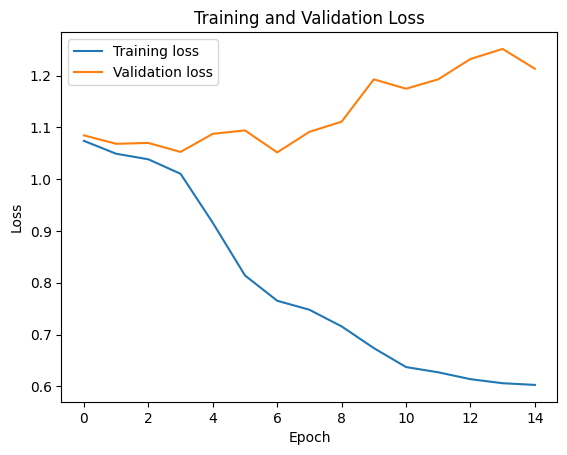

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import torch

# Instantiate the model
model = CNN3D6()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint(5).pth')

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Validation loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == torch.argmax(target, dim=1)).sum().item()

accuracy = correct / total
print(f'Train Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# _, _, e = load_checkpoint(model, optimizer, params_filename)

# 5-fold validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN3D3(nn.Module):
    def __init__(self):
        super(CNN3D3, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(32)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 24 * 24 * 20, 32)
        self.batch_norm_fc = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [ ]:
import shutil
import os

In [ ]:
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join('/content/drive/MyDrive/Checkpoints', filename))

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [ ]:
def train(train_loader, test_loader):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  # Instantiate the model
  model = CNN3D3()
  model.to(device)

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())

  # Initialize the loss arrays
  train_losses = []
  valid_losses = []
  valid_accuracy = []

  # Number of training epochs
  num_epochs = 25

  # Training loop
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode

      epoch_train_loss = 0

      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()  # Zero the gradients

          # Forward pass
          output = model(data)

          # Calculate the loss
          loss = criterion(output, torch.argmax(target, dim=1))
          epoch_train_loss += loss.item()

          # Backward pass
          loss.backward()

          # Update weights
          optimizer.step()

          # Print training statistics
          # if batch_idx % 10 == 0:
          #     print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

      epoch_train_loss = epoch_train_loss / len(train_loader)

      # Validation loop
      model.eval()  # Set the model to evaluation mode
      correct = 0
      total = 0

      epoch_valid_loss = 0

      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              total += target.size(0)
              correct += (predicted == torch.argmax(target, dim=1)).sum().item()
              loss = criterion(output, torch.argmax(target, dim=1))
              epoch_valid_loss += loss.item()

      epoch_valid_loss = epoch_valid_loss / len(test_loader)

      accuracy = correct / total
      print(f'Validation Accuracy: {accuracy * 100:.2f}%')

      train_losses.append(epoch_train_loss)
      valid_losses.append(epoch_valid_loss)
      valid_accuracy.append(accuracy)

      # if epoch % 5 == 0:
      #     save_checkpoint(model, optimizer, epoch, params_filename)

  return train_losses, valid_losses, valid_accuracy

In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
X = images
y = labels

# Convert labels to one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = torch.nn.functional.one_hot(torch.tensor(y_encoded), num_classes=3).float()

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        img_data = img_data / 6482.063678255918

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Define the number of splits for k-fold cross-validation
k = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store accuracies
accuracies = []
train_losses = []
valid_losses = []

# Iterate over each fold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold_idx + 1}/{k}")

    # Split data into train and test sets
    X_train_fold, X_test_fold = np.array(X)[train_index], np.array(X)[test_index]
    y_train_fold, y_test_fold = y_one_hot[train_index], y_one_hot[test_index]

    # Create custom datasets
    train_dataset = CustomDataset(file_paths=X_train_fold, labels=y_train_fold)
    test_dataset = CustomDataset(file_paths=X_test_fold, labels=y_test_fold)

    # Create data loaders
    batch_size = 8
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Train and evaluate your model here
    train_loss, valid_loss, valid_accuracy = train(train_loader, test_loader)

    # Store accuracy for this fold
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracies.append(valid_accuracy)


    # Plot training and validation loss
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss, Fold {fold_idx + 1}')
    plt.legend()
    plt.show()

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracies)
print(f"Average accuracy: {avg_accuracy}")

# playground

In [ ]:
images[0]

In [ ]:
mkdir temp

In [ ]:
cp ADNI/${images[0]} ./temp/

In [ ]:
cd temp

In [ ]:
from PIL import Image
import tensorflow as tf

def load_file(filename):
  return tf.constant(np.array(Image.open(filename.numpy()).convert("L")))

ds = tf.data.Dataset.list_files("*.png")
ds_map = ds.map(lambda x: tf.py_function(load_file, [x], [tf.uint8]))

In [ ]:
list(iter(ds))[0]

In [ ]:
ds_map = ds.map(lambda x: tf.py_function(load_file, [x], [tf.uint8]))

In [ ]:
list(iter(ds_map))[0]

In [ ]:
bytes([68, 68, 69]).decode('utf-8')